In [1]:
import inspect
import gc
import random
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import Functional_Data_functions 
from Functional_Data_functions import HyperParameters, Compile_class,Compile_train,Compare_epochs

from datetime import datetime
import sklearn

import pandas as pd 
from scipy.stats import norm
import pandas as pd
import numpy as np
from numpy import *

import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt

In [2]:
Gpa_raw=pd.read_csv("2024_01_16_GPA_EXTRATION__VEHICULE_VO_VOB_DECISIONS.csv",sep=";",decimal=".")
Gpa_sales=pd.read_csv("Gpa_reco_imputed.csv",)
Gpa_sales
# Gpa_raw.columns
# Gpa_raw['SERIE']



,Unnamed: 0,MARQUE,MODELE,CARBURATION,TYPE_DE_VEHICULE,KILOMETRAGE,DATECIRCUL,DATEENLV,DATECREATION,DATEENTREE,DATEDEBLOC,DATE_AUTORISATION,PTR_BRULE,PTR_IMMERGE,COULEUR,PTR_GRELE,annee_construction,DESTIN2
0,1,5,2768,8,0,169576.0,96114.821766,9594.821766,9762.821766,9378.821766,7506.821766,9618.821766,0,0,6,0,1982,0
1,2,36,1376,8,0,126500.0,75618.821766,9546.821766,9594.821766,9402.821766,8922.821766,9570.821766,0,0,3,0,1985,0
2,3,39,6053,8,0,144626.0,115938.821766,9522.821766,9738.821766,9426.821766,9042.821766,9714.821766,0,0,5,0,2004,0
3,4,5,2744,8,0,177862.0,107370.821766,9426.821766,9522.821766,9354.821766,8394.821766,9522.821766,0,0,3,0,1981,0
4,5,35,2036,1,0,50342.0,40650.821766,8610.821766,8682.821766,8562.821766,6018.821766,8682.821766,0,0,3,0,1989,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12786,12787,39,6213,8,2,241665.0,112842.821766,4698.821766,5586.821766,4674.821766,3858.821766,4746.821766,0,0,3,0,2004,1
12787,12788,36,7158,8,2,216193.0,106338.821766,4026.821766,4146.821766,3882.821766,2730.821766,4074.821766,0,0,3,0,1982,1
12788,12789,50,5410,8,2,172009.0,154194.821766,4362.821766,4554.821766,4338.821766,1146.821766,4362.821766,0,0,5,0,2005,1
12789,12790,18,6931,8,2,196265.0,103002.821766,2826.821766,4866.821766,2826.821766,2178.821766,2898.821766,0,0,3,0,1980,1


In [3]:
def preprocess_input(x_raw):
    x=x_raw.copy()
    # Extraction du dixième caractère de la colonne 'SERIE' et création d'une nouvelle colonne 'dixieme_caractere'
    x['dixieme_caractere'] = x['SERIE'].str[9]
    # Création d'un dictionnaire de correspondance des années
    correspondance_annee = {"A": 1980, "B": 1981, "C": 1982, "D": 1983, "E": 1984,
                            "F": 1985, "G": 1986, "H": 1987, "J": 1988, "K": 1989,
                            "L": 1990, "M": 1991, "N": 1992, "P": 1993, "R": 1994,
                            "S": 1995, "T": 1996, "V": 1997, "W": 1998, "X": 1999,
                            "Y": 2000, "1": 2001, "2": 2002, "3": 2003, "4": 2004,
                            "5": 2005, "6": 2006, "7": 2007, "8": 2008, "9": 2009,
                            "A": 2010, "B": 2011, "C": 2012, "D": 2013, "E": 2014,
                            "F": 2015, "G": 2016, "H": 2017, "J": 2018, "K": 2019,
                            "L": 2020, "M": 2021, "N": 2022, "P": 2023, "R": 2024,
                            "S": 2025, "T": 2026, "V": 2027, "W": 2028, "X": 2029,
                            "Y": 2030, "1": 2031, "2": 2032, "3": 2033, "4": 2034,
                            "5": 2035, "6": 2036, "7": 2037, "8": 2038, "9": 2039}

    # Ajout d'une nouvelle colonne "annee_construction" en utilisant la correspondance
    x['annee_construction'] = x['dixieme_caractere'].map(correspondance_annee)

    # Suppression des colonnes indiquées
    cols_to_drop = ["ORDRE", "CNIT", "DESTIN1", "DECISION", "DESTIN_DESCRIPTION_1", 
                    "DESTIN_DESCRIPTION_2", "DESTIN_DESCRIPTION_3", "PROCEDURE_RSV", 
                    "PROCEDURE_MINE", "PROCEDURE_VE", "PROCEDURE_VVR", "PROCEDURE_CG", 
                    "SERIE", "dixieme_caractere", "RAPPORT_EXPERTISE", "DATE_VENTE"]

    x.drop(columns=cols_to_drop, inplace=True)
    
    date_columns_indices = [i for i, col in enumerate(x.columns) if 'DATE' in col]
    for col_index in date_columns_indices:
        x.iloc[:, col_index] = pd.to_datetime(x.iloc[:, col_index])

    # Calcul du nombre d'années écoulées depuis la date actuelle
    
    x['KILOMETRAGE'] = pd.to_numeric(x['KILOMETRAGE'], errors='coerce')
    for col_index in date_columns_indices:
        x.iloc[:, col_index] = (datetime.today() - x.iloc[:, col_index]).dt.days / 365.25
    
    for column in ['CARBURATION', 'MARQUE', 'TYPE_DE_VEHICULE', 'DESTIN2', 'COULEUR', 'MODELE']:
        x[column] = pd.factorize(x[column])[0]
        

    
    # Gpa_sales=Gpa_sales.drop(DESTIN2)
  
    return x

In [3]:
hyperparam=HyperParameters(n_epochs=50,
    n_conv_in=87,
    n_conv_in2=128,
    n_conv_in3=64,
    n_Flat_out=526,
    dropout=0,
    opt="Adam",
    lr=0.0001,
    loss=nn.CrossEntropyLoss(),

    )

In [4]:
## Model MLP: 
class MLP_model(nn.Module):
    def __init__(self):
        super(MLP_model,self).__init__()
        self.fc_block=nn.Sequential(
            nn.Flatten(),
            nn.Linear(17,87),
            nn.BatchNorm1d(87),
            nn.LeakyReLU(negative_slope=0.17),
            
            
            nn.Linear(87,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.17),
            
            
            nn.Linear(128,526),
            nn.BatchNorm1d(526),
            nn.LeakyReLU(negative_slope=0.17),
            
            
            nn.Linear(526,2),
        )
    
        # if X.shape[0]==1:
        #     X=X.unsqueeze
        
        
        
    def forward(self,x):
        # x = self.preprocess_input(x)
       
        Lin_out=self.fc_block(x)
        
        return Lin_out.float().unsqueeze(2).unsqueeze(3)
    

In [5]:

Y=Gpa_sales.DESTIN2.values
Y=torch.tensor(Y).unsqueeze(1).unsqueeze(2).long().cuda()
# Gpa_sales=Gpa_sales.drop(DESTIN2)
# help(Gpa_sales.drop)
GPA=Gpa_sales.drop(["DESTIN2"],axis=1)

X=torch.Tensor(GPA.values).unsqueeze(1).float().cuda()
print(X.shape,Y.shape)

x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,Y,shuffle=True)
x_train.shape,x_test.shape,y_train.shape,y_test.shape



torch.Size([12791, 1, 17]) torch.Size([12791, 1, 1])


(torch.Size([9593, 1, 17]),
 torch.Size([3198, 1, 17]),
 torch.Size([9593, 1, 1]),
 torch.Size([3198, 1, 1]))

In [8]:

hyperparam.n_conv_in


# MLP=Compile_class(model_class="MLP",hyperparams=hyperparam,x_train=x_train,output_size=2).cuda()

MLP=MLP_model().cuda()
train_function=Compile_train(module=MLP,hyperparams=hyperparam,X=X,Y=Y,p=0.85)
train_tracker=train_function(n_epochs=10)


tensor(94.8411)


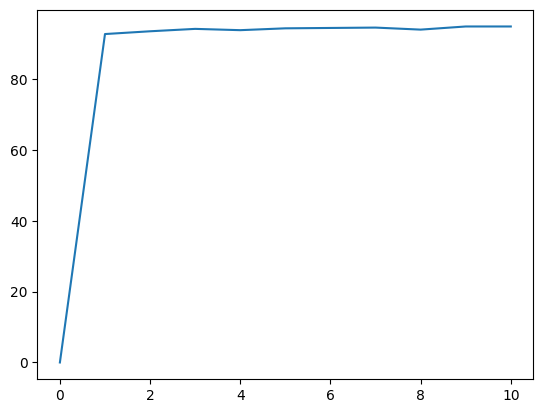

In [9]:
print(train_tracker.max())
plt.plot(train_tracker)



In [10]:
torch.sum(MLP(x_test).argmax(axis=1)==y_test)/y_test.shape[0]
torch.sum(MLP(X).argmax(axis=1)==Y)/Y.shape[0]



tensor(0.9441, device='cuda:0')

<All keys matched successfully>

In [11]:
import torch
import torchvision.models as models

# Télécharger un modèle pré-entraîné, par exemple un modèle de classification d'image
model = MLP
model.eval()

# Sauvegarder le modèle au format "pt"
torch.save(model.state_dict(), 'model.pt')





# Convertir le modèle au format ONNX
# dummy_input = torch.randn(1, 3, 224, 224)  # Exemple d'entrée factice
# torch.onnx.export(model=model, args=x_test, f='modele.onnx')

# help(torch.onnx.export)

In [13]:
# MLP=MLP_model(hyperparams=hyperparam)
model_test=MLP_model().cuda()
model_test.load_state_dict(torch.load('model.pt'))
model_test(x_train)
model_test.eval()
torch.sum(model_test(X).argmax(axis=1)==Y)/Y.shape[0]
# (x_train)

tensor(0.9446, device='cuda:0')